In [1]:
import pandas as pd
import os
import glob
import numpy as np
import pylab as plt
import math
#from loess import *
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
%matplotlib inline

In [2]:
path_home =  "C:/Users/fallet/Documents/220818_Remy pour Mathieu_polarisation/Correction outlier"
#os.chdir(path_home)

exp1 = "KO + EBSS"
exp2 = "KO + iRUFY3 + EBSS"
exp3 = "KO + iRUFY3 + NT"
exp4 = "KO + NT"

path_exp1 = "/KO + EBSS/"
path_exp2 = "/KO + iRUFY3 + EBSS/"
path_exp3 = "/KO + iRUFY3 + NT/"
path_exp4 = "/KO + NT/"

path1 = path_home + path_exp1
path2 = path_home + path_exp2
path3 = path_home + path_exp3
path4 = path_home + path_exp4

# take all csv files except with last pattern "N" if Normalized files was not deleted
csv_files1 = glob.glob(os.path.join(path1, "*[!N].csv"))
csv_files2 = glob.glob(os.path.join(path2, "*[!N].csv"))
csv_files3 = glob.glob(os.path.join(path3, "*[!N].csv"))
csv_files4 = glob.glob(os.path.join(path4, "*[!N].csv"))

In [4]:
# test filtrage avec lowess
'''
y1 = df5["Y"]
x = df5["X"]
filtered = lowess(y1, x, is_sorted=True, frac=0.1, it=0)
#len(pd.DataFrame (filtered))
plt.plot(x, y1, 'r')
#plt.plot(filtered[:,0], filtered[:,1], 'b')
plt.plot(df5["X"], filtered[:,1], 'b')
plt.show()
'''

'\ny1 = df5["Y"]\nx = df5["X"]\nfiltered = lowess(y1, x, is_sorted=True, frac=0.1, it=0)\n#len(pd.DataFrame (filtered))\nplt.plot(x, y1, \'r\')\n#plt.plot(filtered[:,0], filtered[:,1], \'b\')\nplt.plot(df5["X"], filtered[:,1], \'b\')\nplt.show()\n'

In [18]:
# filtrage avec Lowes (fract = 0.1, it=0)
# centrage du max à 0 (entre -180 et 180 degrés)
# normalisation par la somme (conversion en probabilté)

df_filtered = pd.DataFrame()

def NormalizeFiles(csv_files):
    for f in csv_files:
        df = pd.read_csv(f)
        df.rename(columns={"X": "Angle", "Y": "Int"}, inplace=True)
        # commenter la ligne suivante pour le calcul du STD sur les valeurs brutes
        df["Int"] = lowess(df["Int"], df["Angle"], is_sorted=True, frac=0.1, it=0)[:,1]
        sum_Int = df["Int"].sum()
        df["Int"] = df["Int"]/sum_Int
        max_Angle = df["Angle"][df["Int"].argmax()] 
        df["Angle"] = df["Angle"]-max_Angle

        # modulo to convert to [-180 180] degrés
        df.loc[df["Angle"]<(-180), "Angle"] = df["Angle"]%180
        df.loc[df["Angle"]>(180), "Angle"] = df["Angle"]%(-180)
        
        #Sort Int values by angle index from -180 to 180
        df = df.sort_values(by ="Angle" )

        # save df in directory
        temp = os.path.splitext(f)
        f = temp[0]
        name = f+"_N.csv"
        if os.path.exists(name):
            os.remove(name)
        df.to_csv(name) 

In [19]:
NormalizeFiles(csv_files1)
NormalizeFiles(csv_files2)
NormalizeFiles(csv_files3)
NormalizeFiles(csv_files4)

In [20]:
csv_files1_N = glob.glob(os.path.join(path1, "*_N.csv"))
csv_files2_N = glob.glob(os.path.join(path2, "*_N.csv"))
csv_files3_N = glob.glob(os.path.join(path3, "*_N.csv"))
csv_files4_N = glob.glob(os.path.join(path4, "*_N.csv"))

In [21]:
# std dev calcul après centrage à 0 et normalisation/la somme 
# E[X] = Sum (x_i * p(x_i)) 
# avec x_i c'est l'angle et p(x_i) c'est la valeur 
# Var(X) = Sum( x_i^2 * p(x_i))  - E[X]^2
# std = sqrt( Var[X])

def StdDev(csv_files_N):
    # esperance puis variance
    std_all = []
    for f in csv_files_N:
        df = pd.read_csv(f)
        xi = df['Angle']
        pi = df['Int']
        df['Esperance'] = xi * pi
        Esperance = df['Esperance'].sum()
        #print("esperance="+str(Esperance))
        df['Xi2*pi'] = xi*xi*pi
        Somme = df['Xi2*pi'].sum()
        var = Somme - Esperance*Esperance
        std = math.sqrt(abs(var))
        #print(std)
        std_all.append(std)
    std_all = pd.DataFrame(std_all, columns=['Std'])
       
    # write std dev file
    temp = os.path.splitext(f)
    f = temp[0]
    name = f+"_StdDev.csv"
    if os.path.exists(name):
       os.remove(name)
    std_all.to_csv(name)  

In [22]:
StdDev(csv_files1_N)
StdDev(csv_files2_N)
StdDev(csv_files3_N)
StdDev(csv_files4_N)

In [23]:
def MeanProfile(csv_files_N,path_out,exp):
    
    angle = np.arange(-180, 180, 1)
    df_mean = pd.DataFrame({"Angle":angle})
    df_all = pd.DataFrame()

    for f in csv_files_N:
        df = pd.read_csv(f)
        df = df['Int']
        
        # concatenate df in X 
        df_all = pd.concat([df_all,df], axis=1)
        
    # make the mean of all row
    mean = df_all.mean(axis = 1)
    # create a column "Int" and put the values mean
    df_mean["Int"] = mean
        
    # Normalize in Intensity
    #sum_Int = df_mean['Int'].sum()
    #df_mean['Int'] = df_mean['Int']*100/sum_Int    
        
    # save mean profile
    name = path_out+exp+"_mean_N.csv"
    if os.path.exists(name):
        os.remove(name)
    df_mean.to_csv(name)

In [24]:
MeanProfile(csv_files1_N, path1, exp1)
MeanProfile(csv_files2_N, path2, exp2)
MeanProfile(csv_files3_N, path3, exp3)
MeanProfile(csv_files4_N, path4, exp4)

In [25]:
df_mean_1 = pd.read_csv(path1 + exp1 +"_mean_N.csv")
df_mean_2 = pd.read_csv(path2 + exp2 +"_mean_N.csv")
df_mean_3 = pd.read_csv(path3 + exp3 +"_mean_N.csv")
df_mean_4 = pd.read_csv(path4 + exp4 +"_mean_N.csv")

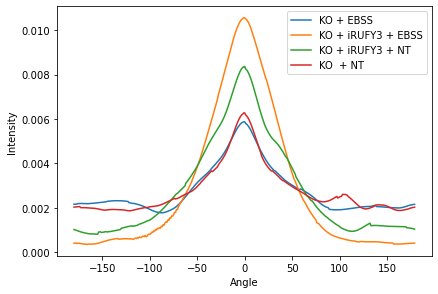

In [31]:
# overlay curves
Y1 = df_mean_1['Int']
Y2 = df_mean_2['Int']
Y3 = df_mean_3['Int']
Y4 = df_mean_4['Int']

X = angle = np.arange(-180, 180, 1)

plt.plot(X, Y1, label = "KO + EBSS")
plt.plot(X, Y2, label = "KO + iRUFY3 + EBSS")
plt.plot(X, Y3, label = "KO + iRUFY3 + NT")
plt.plot(X, Y4, label = "KO  + NT")

plt.tight_layout()
plt.xlabel("Angle")
plt.ylabel("Intensity")
plt.legend()
plt.savefig('Superposition.png',dpi=600)
plt.show()

In [28]:
# bin profile
# bin=30
# 360/30 =12 valeurs

def BinProfile(df_mean, path_out,exp):
    bin1 = np.zeros((12,30))
    b = pd.DataFrame()

    # Bin mean (bin=30)
    b = df_mean['Int'].tolist()              
    for i in range (0,360,30):
        k=int(i/30)
        mean=(b[i] + b[i+1] + b[i+2] + b[i+3] + b[i+4] + b[i+5] + b[i+6] + b[i+7] + b[i+8] + b[i+9] + b[i+10] + b[i+11] + b[i+12] + b[i+13] + b[i+14] + b[i+15] + b[i+16] + b[i+17] + b[i+18] + b[i+19] + b[i+20] + b[i+21] + b[i+22] + b[i+23] + b[i+24] + b[i+25] + b[i+26] + b[i+27] + b[i+28] + b[i+29])/30
        for j in range(30):
            bin1[k,j]=mean
    bin1 = pd.DataFrame(bin1)
    #bin1.rename(columns={"0": "Int"}, inplace=True)
    #print("Bin Mean: \n",bin1)
    #plt.plot(bin1)
    #bin1.shape()
    #sum_Int = bin1.sum()
    #bin1 = bin1*100/sum_Int  
    
    # save bin profile
    name = path_out+exp+"_mean_bin_N.csv"
    if os.path.exists(name):
        os.remove(name)
    bin1.to_csv(name)
 

In [29]:
BinProfile(df_mean_1,path1,exp1)
BinProfile(df_mean_2,path2,exp2)
BinProfile(df_mean_3,path3,exp3)
BinProfile(df_mean_4,path4,exp4)

df_mean_1_bin = pd.read_csv(path1 + exp1 +"_mean_bin_N.csv")
df_mean_2_bin = pd.read_csv(path2 + exp2 +"_mean_bin_N.csv")
df_mean_3_bin = pd.read_csv(path3 + exp3 +"_mean_bin_N.csv")
df_mean_4_bin = pd.read_csv(path4 + exp4 +"_mean_bin_N.csv")
#df_mean_5_bin = pd.read_csv(path5 + exp5 +"_mean_bin_N.csv")

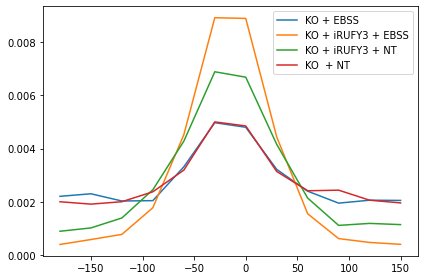

In [30]:
# overlay bin curves
Y1 = df_mean_1_bin['0']
Y2 = df_mean_2_bin['0']
Y3 = df_mean_3_bin['0']
Y4 = df_mean_4_bin['0']
#Y5 = df_mean_5['Int']

#X = df_mean_1['Angle']
X = angle = np.arange(-180, 180, 30)

fig = plt.figure()
plt.plot(X, Y1, label = "KO + EBSS")
plt.plot(X, Y2, label = "KO + iRUFY3 + EBSS")
plt.plot(X, Y3, label = "KO + iRUFY3 + NT")
plt.plot(X, Y4, label = "KO  + NT")
#plt.plot(X, Y5, label = "Test")

plt.tight_layout()
#plt.xlabel("Angle")
#plt.ylabel("Intensity")
plt.legend()
plt.savefig('Superposition.png',dpi=600)
plt.show()

In [ ]:
# Fit Y0
import matplotlib.pyplot as plt
from scipy import asarray as ar, exp, sqrt
from scipy.optimize import curve_fit

angles = ar(X)
data = ar(Y4)

n = len(data)  
mean = sum(data*angles)/n
sigma = sqrt(sum(data*(angles-mean)**2)/n)
#a = 18
Y0 = 10

def gaus(x,a,mu,sigma,Y0):
    return Y0 + a*exp(-(x-mu)**2/(2*sigma**2))

popt,pcov = curve_fit(gaus,angles,data)#,p0=[0.18,mean,sigma])  ## <--- leave out the first estimation of the parameters
xx = np.linspace( -180, 180, 10 )  ## <--- calculate against a continuous variable
print("Y0="+str(popt[3]))

In [ ]:
fig = plt.figure()
plt.plot(angles, data, "ob", label = "Measured")
plt.plot(xx,gaus(xx,*popt),'r',label='Fit')  ## <--- plot against the contious variable
plt.xlim(-180, 180)
plt.ylim(0, 100)
plt.xticks(angles)
plt.title("")
plt.xlabel("Angle")
plt.ylabel("Int")
plt.grid()
plt.legend()
#plt.savefig('normal.png')
plt.show()